## performing sentiment classification using BERT
 (from film reviews)
## Steps :
1) using DistilBERT which is a lighter version of BERT to process the text (then BERT and Large BERT)            
2) classify the reviews using Logistic Regression from Scikit-Learn as either positive (1) or negative (0)

## Importing the dataset

In [76]:
import pandas as pd
data=pd.read_csv("train.csv",delimiter="\t", header=None,names=["review","class"])
data

,review,class
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1
6916,take care is nicely performed by a quintet of ...,0
6917,"the script covers huge , heavy topics in a bla...",0
6918,a seriously bad film with seriously warped log...,0


In [77]:
batch_1=data[:2000]

In [78]:
# how many sentiments are labeled as "positive" and how many are labeled "negative"
print("class 1 :")
print(batch_1[batch_1["class"]==1].count())
print()
print("class 0 :")
print(batch_1[batch_1["class"]==0].count())
# or :
batch_1["class"].value_counts()

class 1 :
review    1041
class     1041
dtype: int64

class 0 :
review    959
class     959
dtype: int64


1    1041
0     959
Name: class, dtype: int64

## Loading the pretrained BERT model

### Importing relevant libraries (bert)

In [79]:
import numpy as np
import torch
import transformers
import warnings
warnings.filterwarnings('ignore')

<a id="switch-model"></a>

In [80]:
#for DistilBERT:
model_class,tokenizer_class,pretrained_weights=(transformers.DistilBertModel,transformers.DistilBertTokenizer,'distilbert-base-uncased')

#for BERT:
#model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

#for Large BERT :
#model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-large-uncased')

tokenizer=tokenizer_class.from_pretrained(pretrained_weights) # create an instance of the DistilBertTokenizer class
model=model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## tokenization
the input text is to be converted into a format that can be processed by the BERT model (encoding)

In [81]:
# tokenizing the text (splitting it into tokens) in the column using the pre-trained tokenizer, 
# and adding special tokens to the beginning and end of the tokenized sequences
tokenized=batch_1["review"].apply((lambda x: tokenizer.encode(x,add_special_tokens=True)))

"""special tokens include:
* the [CLS] token at the beginning, which is a classification token that indicates the start of the input,
* and the [SEP] token at the end, which is a separator token that indicates the end of the input

OUTPUT: a list of sentences, each sentences is represented as a list of tokens
"""

'special tokens include:\n* the [CLS] token at the beginning, which is a classification token that indicates the start of the input,\n* and the [SEP] token at the end, which is a separator token that indicates the end of the input\n\nOUTPUT: a list of sentences, each sentences is represented as a list of tokens\n'

In [82]:
print(tokenized[0])
print(tokenized[1])
# each token is expressed as an integer
# [CLS] index is 101 and [SEP] ind is 102
print()
print(tokenized.values)
# a list of lists
# lists don't have the same length !

[101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102]
[101, 4593, 2128, 27241, 23931, 2013, 1996, 6276, 2282, 2723, 1997, 2151, 2445, 12217, 7815, 102]

[list([101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102])
 list([101, 4593, 2128, 27241, 23931, 2013, 1996, 6276, 2282, 2723, 1997, 2151, 2445, 12217, 7815, 102])
 list([101, 2027, 3653, 23545, 2037, 4378, 24185, 1050, 1005, 1056, 4133, 2145, 2005, 1037, 11507, 10800, 1010, 2174, 14036, 2135, 3591, 1010, 2061, 2027, 19817, 4140, 2041, 1996, 7511, 2671, 4349, 3787, 1997, 11829, 7168, 9219, 1998, 28971, 2308, 1999, 8301, 8737, 2100, 4253, 102])
 ...
 list([101, 2023, 2028, 8704, 2005, 1996, 11848, 1998, 7644, 1037, 3622, 2718, 102])
 list([101, 1999, 1996, 2171, 1997, 2019, 9382, 18988, 1998, 4089, 3006, 3085, 17312, 1010, 1996, 3750, 1005, 1055, 2252, 4332, 1037, 6397, 3239, 2000, 1996, 2200, 2381, 2

## padding
pad all lists to the same size to feed them to the model at once (we need to add extra elements to the shorter lists so that all lists have the same length)

In [83]:
# we want to retrieve max len by itering over lists in tokenized
max_len=len(tokenized.values[0])
for lst in tokenized.values:
    if len(lst)>max_len:
        max_len=len(lst)
print(max_len)

### adding 0 in the ending of each list in order to have all lists with same len which is 59
# matrix (2000, 59)
padded=np.array([lst+ [0]*(max_len-len(lst)) for lst in tokenized.values])
padded

59


array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  2023,  2028, ...,     0,     0,     0],
       [  101,  1999,  1996, ...,     0,     0,     0],
       [  101,  1996,  3185, ...,     0,     0,     0]])

In [84]:
padded.shape

(2000, 59)

## masking
The attention_mask is an array of the same shape as the padded array that contains only 0 and 1. The purpose of the attention_mask is to indicate to the BERT model which tokens in the padded array correspond to real input (i.e., the original sequence) and which tokens correspond to padding, assuming that padding tokens do not carry any meaningful information...

In [85]:
"""we'll create a binary mask, an array where each element is 1 
if the corresponding element of the padded array is non-zero (i.e. a real token) 
and 0 otherwise (i.e. a padding token)
"""
attention_mask = np.where(padded!= 0, 1, 0) # if !=0 assign 1, 0 otherwise
print(attention_mask.shape)
attention_mask

(2000, 59)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

## Implementing the model

In [86]:
inputs=torch.tensor(padded)
attention_mask=torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states=model(inputs, attention_mask=attention_mask) #generating the final output embeddings of BERT
"""last_hidden_states tensor contains the final hidden states of all tokens in the input sentences,
where each token is represented by a 768-dimensional vector (bert:12 layers x 12 heads x 64 dimensions per head)
PS: BERT large model has 24 layers, each with 1,024 hidden units
"""

'last_hidden_states tensor contains the final hidden states of all tokens in the input sentences,\nwhere each token is represented by a 768-dimensional vector (bert:12 layers x 12 heads x 64 dimensions per head)\nPS: BERT large model has 24 layers, each with 1,024 hidden units\n'

In [87]:
print(last_hidden_states[0]) #the tensor containing the hidden states for all tokens (3 dims!)
last_hidden_states[0].shape

tensor([[[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
         [-0.2471,  0.2468,  0.1008,  ..., -0.1631,  0.9349, -0.0715],
         [ 0.0558,  0.3573,  0.4140,  ..., -0.2430,  0.1770, -0.5080],
         ...,
         [-0.0165,  0.1179,  0.3512,  ..., -0.2401,  0.2722, -0.1750],
         [ 0.0961,  0.0667,  0.3147,  ..., -0.3277,  0.3556, -0.2135],
         [ 0.0454,  0.0519,  0.3168,  ..., -0.2880,  0.1844, -0.1042]],

        [[-0.1726, -0.1448,  0.0022,  ..., -0.1744,  0.2139,  0.3720],
         [ 0.0022,  0.1684,  0.1269,  ..., -0.1888, -0.0195, -0.0283],
         [ 0.0257, -0.2458,  0.0717,  ..., -0.4339,  0.1622,  0.0133],
         ...,
         [ 0.0505, -0.0493,  0.0463,  ..., -0.0448, -0.0540,  0.3136],
         [-0.2128, -0.1906, -0.0215,  ...,  0.0139, -0.2433, -0.0202],
         [-0.1310, -0.1693,  0.1019,  ..., -0.0859, -0.1770, -0.0872]],

        [[-0.0506,  0.0720, -0.0296,  ..., -0.0715,  0.7185,  0.2623],
         [ 0.0536,  0.3136, -0.0598,  ...,  0

torch.Size([2000, 59, 768])

In [88]:
# first sentence
print(last_hidden_states[0][0].shape)
last_hidden_states[0][0]
#each row correponds to a column

torch.Size([59, 768])


tensor([[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
        [-0.2471,  0.2468,  0.1008,  ..., -0.1631,  0.9349, -0.0715],
        [ 0.0558,  0.3573,  0.4140,  ..., -0.2430,  0.1770, -0.5080],
        ...,
        [-0.0165,  0.1179,  0.3512,  ..., -0.2401,  0.2722, -0.1750],
        [ 0.0961,  0.0667,  0.3147,  ..., -0.3277,  0.3556, -0.2135],
        [ 0.0454,  0.0519,  0.3168,  ..., -0.2880,  0.1844, -0.1042]])

The [CLS] token is added at the beginning of every sentence when using BERT for sentence classification tasks. It is used to represent the entire sentence as an embedding. We can say that the output stored in [CLS] is a vector representation of the entire sentence that is used for the classification task.

In [89]:
features = last_hidden_states[0][:,0,:].numpy() #accessing the first element [CLS] (col) in each dim (depth) and for each sent(row)
features # each list contains all [CLS] from all dim correp to each sent

array([[-0.21593435, -0.14028923,  0.0083111 , ..., -0.13694862,
         0.5867003 ,  0.20112729],
       [-0.17262715, -0.14476168,  0.00223415, ..., -0.17442568,
         0.21386464,  0.37197477],
       [-0.05063343,  0.07203943, -0.02959692, ..., -0.07148942,
         0.7185239 ,  0.26225492],
       ...,
       [-0.27829772, -0.24803595,  0.13585807, ..., -0.19039167,
         0.13099585,  0.34978363],
       [-0.03667746,  0.10638566, -0.0111101 , ..., -0.11206651,
         0.41619456,  0.50337994],
       [ 0.12402612,  0.01425173,  0.01038412, ..., -0.11606546,
         0.5345916 ,  0.27495354]], dtype=float32)

In [90]:
labels=batch_1["class"] #1 for positive and 0 for negative

## training

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [92]:
#split the dataset into train dataset and test one
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=.25,random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1500
500
1500
500


### GridSearchCV to find the best C parameter

In [93]:
#C_range=10**np.arange(-4.,3.,1)
#parameters = {'C': np.linspace(0.0001, 100, 10)}
C_range=10.0**np.arange(-4,3,1) # from 10^-4 to 10^2
params={'C':C_range}
lr=LogisticRegression()
gs_lr=GridSearchCV(LogisticRegression(),params,n_jobs=-1,cv=5)
gs_lr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

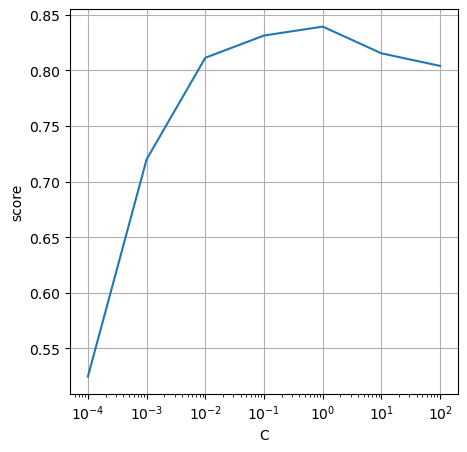

In [94]:
import matplotlib.pyplot as plt
scores = gs_lr.cv_results_['mean_test_score']
plt.figure(figsize=[5,5])
plt.semilogx(C_range,scores)
plt.xlabel('C')
plt.ylabel('score')
plt.grid()
plt.show();

In [95]:
print("best estimator :")
print(gs_lr.best_params_)
print("best score: ", gs_lr.best_score_)

best estimator :
{'C': 1.0}
best score:  0.8393333333333335


In [96]:
#best C parameter is C=1
# training
lr_C=LogisticRegression(C=1)
lr_C.fit(X_train,y_train)
print("fitted")

fitted


# Results &performance

In [97]:
y_pred_lr=lr_C.predict(X_test)
#the performance on the test set
print("Score on the test set : ",lr_C.score(X_test,y_test))
print()
# accuracy score between y_true&y_pred
print("Accuracy score : ", metrics.accuracy_score(y_test, y_pred_lr))
print()
scores_LR = cross_val_score(lr_C,X_train,y_train,cv=5)
print("cross validation mean score : %0.3f (+/- %0.3f)" % (scores_LR.mean(),2*scores_LR.std()))
print()
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test,y_pred_lr))
print()
print("Some relevant metrics :")
print(metrics.classification_report(y_test,y_pred_lr)) 

Score on the test set :  0.84

Accuracy score :  0.84

cross validation mean score : 0.839 (+/- 0.048)

Confusion Matrix:
[[203  43]
 [ 37 217]]

Some relevant metrics :
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       246
           1       0.83      0.85      0.84       254

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



## Possible way of improving results

1) Switching to BERT and then Large-bert , <a href="#switch-model">Clic to switch model</a> by uncommenting appropriate codes.

2) Fine-tuning the model which updates BERT's (the three models) weights to achieve a better performance.

## BERT results

In [ ]:
"""
Score on the test set :  0.856

Accuracy score :  0.856

cross validation mean score : 0.841 (+/- 0.035)

Confusion Matrix:
[[210  36]
 [ 36 218]]

Some relevant metrics :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       246
           1       0.86      0.86      0.86       254

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500

"""

### Comments :
Both false positive and false negative slightly decreased which led to a tiny increase in score.

## Large BERT results

In [ ]:
"""
provides approximately the same results, nothing special to report
"""

## Remarks

Both the original BERT and Large BERT (especially Large BERT!!) take time to process data but eventually provide better results. More captivating results are expected with more intricate data (larger datasets??). Finally, using the second method will (surely) further improve performance...